In [47]:
from typing import Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

## ベクトル自己回帰(VAR)モデルを調べる

In [6]:
df_macro = sm.datasets.macrodata.load_pandas().data
df_macro.index = pd.PeriodIndex(
    df_macro.apply(lambda ser: f"{int(ser['year'])}Q{int(ser['quarter'])}", axis=1),
    freq='Q', name='date'
)
df_macro.drop(columns=['year', 'quarter'], inplace=True)
df_macro = df_macro[['realdpi', 'realcons']]
df_macro.head(10)

,realdpi,realcons
date,,
1959Q1,1886.9,1707.4
1959Q2,1919.7,1733.7
1959Q3,1916.4,1751.8
1959Q4,1931.3,1753.7
1960Q1,1955.5,1770.5
1960Q2,1966.1,1792.9
1960Q3,1967.8,1785.8
1960Q4,1966.6,1788.2
1961Q1,1984.5,1787.7


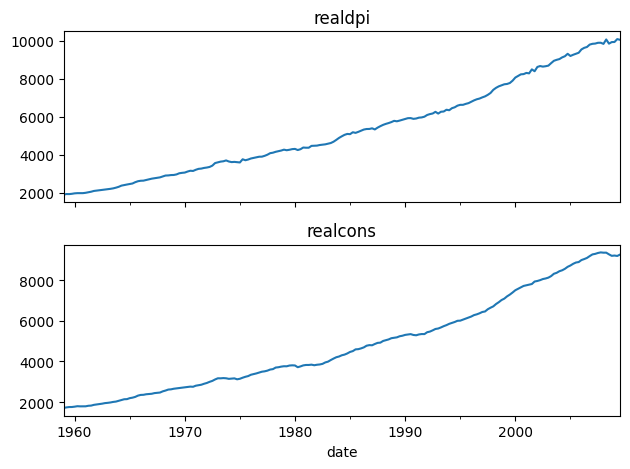

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True)
for i in range(2):
    axes[i].set_title(df_macro.columns[i])
    df_macro.iloc[:, i].plot(ax=axes[i])
fig.tight_layout()

## VAR(p)モデルのモデル化手続きを設計する

## 実質可処分所得と実質消費支出を予測する

In [14]:
# 定常性の確認
for i in range(2):
    for d in [0, 1]:
        ADF_result = adfuller(np.diff(df_macro.iloc[:, i], n=d))
        print(f'{df_macro.columns[i]}({d}次差分)ADF検定')
        print(f'ADF Statistic: {ADF_result[0]:.3f}')
        print(f'p-value: {ADF_result[1]:.3f}')
    print('===================')

realdpi(0次差分)ADF検定
ADF Statistic: 2.986
p-value: 1.000
realdpi(1次差分)ADF検定
ADF Statistic: -8.865
p-value: 0.000
realcons(0次差分)ADF検定
ADF Statistic: 1.550
p-value: 0.998
realcons(1次差分)ADF検定
ADF Statistic: -4.204
p-value: 0.001


In [17]:
# VARモデルを適合させて最もAICが小さくなるモデルを選択する関数
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    res = []
    # 次数を14まで変化
    for i in tqdm(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(disp=False)
        except:
            continue
        res.append([i, model.aic])
    return pd.DataFrame(res, columns=['p', 'AIC']).sort_values('AIC').reset_index(drop=True)

In [24]:
train = df_macro.diff()[1:][:162]
test = df_macro.diff()[1:][162:]

optimize_VAR(train)

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855594
3,4,3129.194047
4,2,3130.091668
5,7,3133.398358
6,1,3134.333343
7,8,3137.149011
8,9,3140.367177
9,10,3147.838680


In [37]:
# p=3が最適であることがわかった
# グレンジャー因果性の検定
print(f'{df_macro.columns[1]} Granger-causes {df_macro.columns[0]}?')
granger1 = grangercausalitytests(
    df_macro.diff().iloc[1:, [0, 1]],
    maxlag=[3],
)
print(f'\n{df_macro.columns[0]} Granger-causes {df_macro.columns[1]}?')
granger1 = grangercausalitytests(
    df_macro.diff().iloc[1:, [1, 0]],
    maxlag=[3],
)

realcons Granger-causes realdpi?

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [40]:
# p値がいずれも0.05よりも小さいので実際に予測に進む
model = VARMAX(train, order=(3, 0)).fit(disp=False)

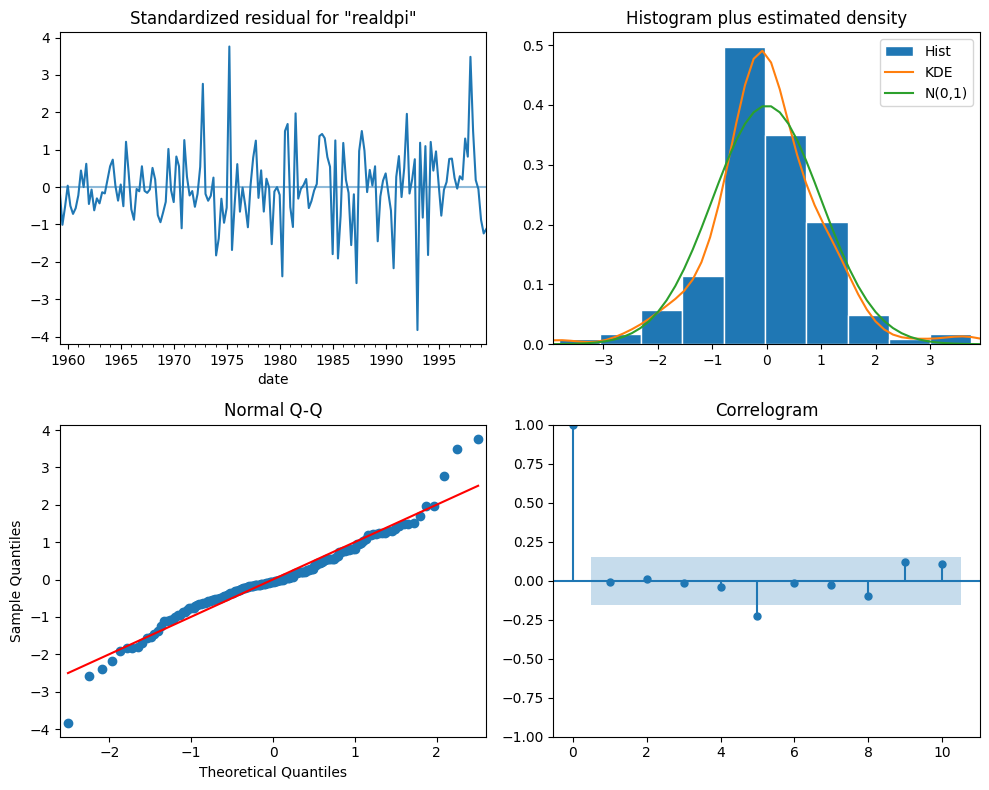

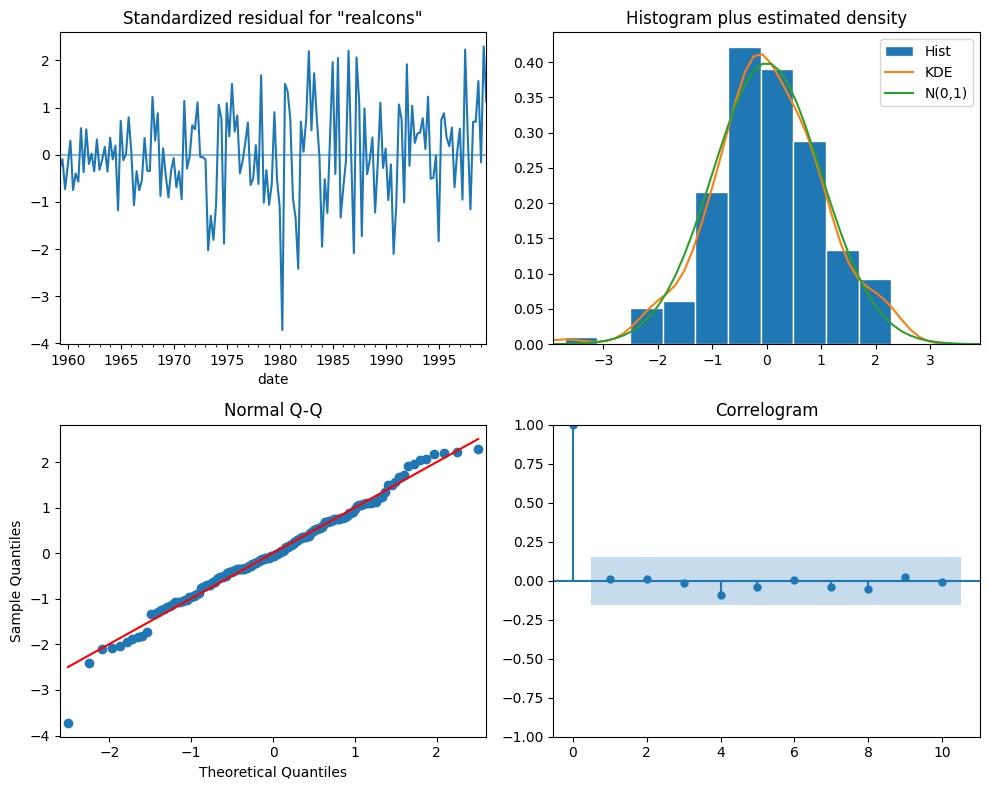

In [45]:
# 残差分析
for i in range(2):
    model.plot_diagnostics(figsize=(10, 8), variable=i)
    plt.tight_layout()

In [57]:
# 相関がないかの検定も行う
for i in range(2):
    print(f'{df_macro.columns[i]}')
    display(acorr_ljungbox(model.resid.iloc[:, i], np.arange(1, 11)))

realdpi


,lb_stat,lb_pvalue
1,0.011641,0.914079
2,0.029410,0.985403
3,0.075796,0.994575
4,0.378020,0.984237
5,9.142892,0.103499
6,9.165748,0.164469
7,9.270487,0.233815
8,10.812127,0.212573
9,13.318498,0.148716
10,15.287698,0.121920


realcons


,lb_stat,lb_pvalue
1,0.023757,0.877505
2,0.068698,0.966234
3,0.068777,0.995301
4,0.235628,0.993582
5,0.377556,0.995925
6,0.787230,0.992412
7,1.015086,0.994581
8,2.150240,0.976056
9,2.436944,0.982531
10,2.442617,0.991686


In [58]:
# p値がいずれも0.05よりも大きかったので無相関であることを確認できた
# このまま予測を行おう
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    idx_end = train_len
    
    preds_realdpi = []
    preds_realcons = []
    
    if method == 'VAR':
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3, 0)).fit(disp=False)
            pred = model.get_prediction(0, i + window - 1)
            preds_realdpi.extend(
                pred.predicted_mean.iloc[-window:]['realdpi']
            )
            preds_realcons.extend(
                pred.predicted_mean.iloc[-window:]['realcons']
            )
    elif method == 'last':
        for i in range(train_len, total_len, window):
            preds_realdpi.extend(
                df[:i].iloc[-1]['realdpi'] for _ in range(window)
            )
            preds_realcons.extend(
                df[:i].iloc[-1]['realcons'] for _ in range(window)
            )
    return preds_realdpi, preds_realcons

In [62]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

preds_realdpi_VAR, preds_realcons_VAR = rolling_forecast(
    df_macro.diff()[1:], TRAIN_LEN, HORIZON, WINDOW, 'VAR'
)
preds_realdpi_last, preds_realcons_last = rolling_forecast(
    df_macro.diff()[1:], TRAIN_LEN, HORIZON, WINDOW, 'last'
)

In [74]:
# 和分に変換
test = df_macro[163:]
test['realdpi_pred_VAR'] = df_macro.iloc[162, 0] + np.cumsum(preds_realdpi_VAR)
test['realcons_pred_VAR'] = df_macro.iloc[162, 1] + np.cumsum(preds_realcons_VAR)
test['realdpi_pred_last'] = df_macro.iloc[162, 0] + np.cumsum(preds_realdpi_last)
test['realcons_pred_last'] = df_macro.iloc[162, 1] + np.cumsum(preds_realcons_last)
test.head()

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
date,,,,,,
1999Q4,7887.7,7389.2,7829.224941,7354.323079,7815.8,7372.9
2000Q1,8053.4,7501.3,7897.190077,7430.252000,7865.7,7459.4
2000Q2,8135.9,7571.8,7960.564871,7496.624306,7915.6,7545.9
2000Q3,8222.3,7645.9,8014.757071,7556.606726,7965.5,7632.4
2000Q4,8234.6,7713.5,8080.701763,7630.989437,8051.9,7706.5


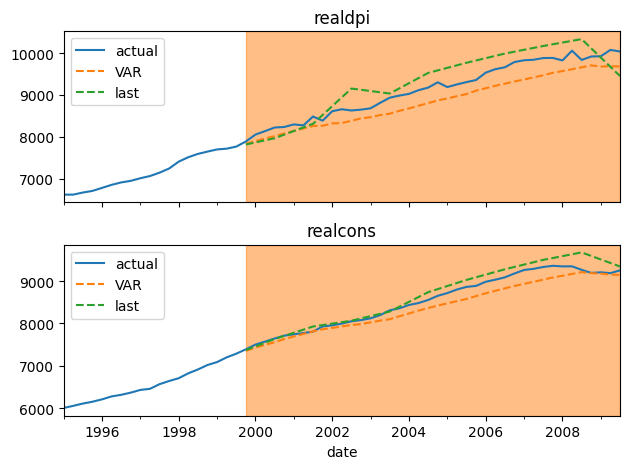

In [88]:
# plot
fig, axes = plt.subplots(2, 1, sharex=True)
# realdpi
axes[0].set_title('realdpi')
df_macro['realdpi']['1995':].plot(ax=axes[0], label='actual')
axes[0].axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
test['realdpi_pred_VAR'].plot(ax=axes[0], label='VAR',ls='dashed')
test['realdpi_pred_last'].plot(ax=axes[0], label='last',ls='dashed')
axes[0].legend()
# realcons
axes[1].set_title('realcons')
df_macro['realcons']['1995':].plot(ax=axes[1], label='actual')
axes[1].axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
test['realcons_pred_VAR'].plot(ax=axes[1], label='VAR',ls='dashed')
test['realcons_pred_last'].plot(ax=axes[1], label='last',ls='dashed')
axes[1].legend()
fig.tight_layout()

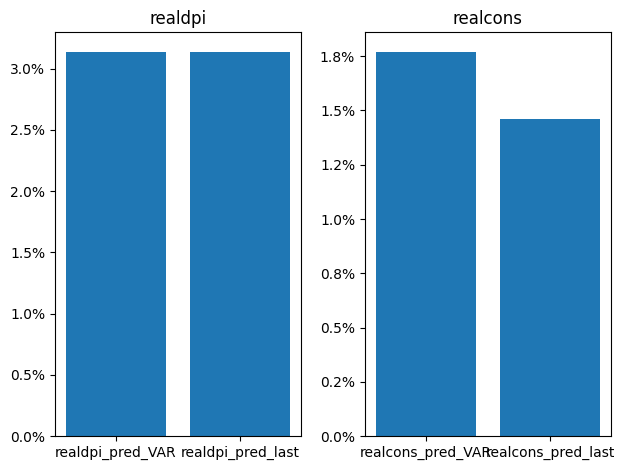

In [95]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

fig, axes = plt.subplots(1, 2)
# realdpi
axes[0].set_title('realdpi')
xs = ['realdpi_pred_VAR', 'realdpi_pred_last']
ys = [mape(test['realdpi'], test[x]) for x in xs]
axes[0].bar(xs, ys)
axes[0].yaxis.set_major_formatter(lambda y, _: '{:.01%}'.format(y))
# realcons
axes[1].set_title('realcons')
xs = ['realcons_pred_VAR', 'realcons_pred_last']
ys = [mape(test['realcons'], test[x]) for x in xs]
axes[1].bar(xs, ys)
axes[1].yaxis.set_major_formatter(lambda y, _: '{:.01%}'.format(y))
fig.tight_layout()